# Flows on graphs
In this lab we present the Ford Fulkerson algorithm for finding the maximum admissible flow on a capacitated network and we explore its connections with the Max Flow - Min Cut theorem. 

Then we present network flow optimization problems, which consist in finding a flow vector that maximize/minimize some objective subject to network constraints, and we see how to use CVXPY to solve them. 

## Max Flow - Min Cut Theorem and the Ford Fulkerson algorithm
It is given a graph $G = (V, E)$ which represents a flow network and two vertices source ‘s’ and sink ‘t’ in it. Every edge $(u,v)$ has a capacity $c(u,v)$. We want to find the maximum possible flow from s to t with the following constraints:

1. Flow on an edge doesn’t exceed the given capacity of the edge.
2. Incoming flow is equal to outgoing flow for every vertex except s and t.

The desired flow $f$ is constructed iteratively starting from a zero-flow vector: at each round of the algorithm $f$ is updated in such a way that the capacity and balance constraints are not violated.

To do this, at each round, given the current flow vector $f$, we define the **residual network** $G_{f}(V,E_{f})$ to be the network with capacity $c_{f}(u,v)=c(u,v)-f(u,v)$. A search on the residual graph $G_f$ is performed to find an **augmenting path**: an origin-destination path that possess some residual capacity. If an augmenting path is found, this means that the current flow $f$ on that path can be increased.

### Ford–Fulkerson Algorithm 
**Inputs**: a graph $G=(V,E)$, a vector of flow capacities $c = (c(u,v))_{(u,v) \in E}$, a source node s, and a sink node t

**Output**: a flow $f = (f(u,v))_{(u,v) \in E}$ from s to t of maximum throughput

1. $f(u,v)\leftarrow 0$ for all edges $(u,v)$
2. While there is a path p from s to t in $G_{f}$, such that $c_{f}(u,v)=c(u,v)-f(u,v)>0$ for all edges $(u,v)\in p$:
 1. Find $c_{f}(p)=\min\{c_{f}(u,v):(u,v)\in p\}$
 2. For each edge $(u,v)\in p$
  1. $f(u,v)\leftarrow f(u,v)+c_{f}(p)$ (Increase the flow along the path)
  2. $f(v,u)\leftarrow f(v,u)-c_{f}(p)$ (Impose the symmetry of the flow)

The path in step 2 can be found, for example, with a breadth-first search (BFS) or a depth-first search in $G_{f}(V,E_{f})$. If you use the former, the algorithm is called Edmonds–Karp.

### Edmonds-Karp Algorithm
The Edmonds–Karp algorithm is identical to the Ford–Fulkerson algorithm, except that the search order when finding the augmenting path is defined. A shortest path that has available capacit is found by a breadth-first search.

In [1]:
import collections
import numpy as np

# This class represents a directed graph using adjacency matrix representation
class Graph:
    # __init__ is a reseved method in python classes.
    # In object oriented terminology, it is the constructor of the class.
    def __init__(self, graph): 
        # the Graph object represents the flow network and the graph
        # attribute will be updated by the Edmonds-Karp Algorithm to 
        # represent the residual graph.
        # Entry [u][v] of graph array stores the capacity of link (u,v).
        self.graph = graph  
        # Number of nodes:
        self.ROW = len(graph)

    def bfs(self, s, t, parent):
        """Returns true if there is a path from source 's' to sink 't' in the
        residual graph. Also fills parent[] to store the path """

        # Mark all the vertices as not visited
        visited = [False] * (self.ROW)
        
        s = np.argwhere(np.array(self.graph.nodes) == s).item()
        t = np.argwhere(np.array(self.graph.nodes) == t).item()

        # Create a double-ended queue for BFS
        queue = collections.deque()

        # Mark the source node as visited and enqueue it
        # When visited, nodes are appended "to the right end" of the queue.
        queue.append(s)
        visited[s] = True

        # Standard BFS loop
        while queue: # while there are still elements in the queue
            # Nodes are extracted from "the left end" of the queue
            u = np.array(self.graph.nodes)[queue.popleft()]
            try:
                u = int(u)
            except:
                continue

            # Get all adjacent vertices of the dequeued vertex u
            # If an adjacent vertex has not been visited, then mark 
            # it as visited and enqueue it.
            
            # Enumerate() method adds a counter to an iterable
            # to keep a count of iterations. We cycle over row
            # u of graph array: ind is the index of the node,
            # val is >0 if node ind is adjacent to u, i.e. if 
            # there is residual capacity on the link (u,ind),
            # it is 0 otherwise.
            for ind, val in enumerate(self.graph[u]): 
                if (visited[ind] == False) and (val > 0):
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        # If sink is reached by BFS starting from source, then return
        # true, else return false
        return visited[t]

    # Returns the maximum flow from s to t in the given graph
    def edmonds_karp(self, source, sink):

        # parent array is filled by bfs() and it is used 
        # to compute augmenting paths.
        # It is initialized with the sentinel value -1
        parent = [-1] * (self.ROW)

        # Both max flow value and max flow vector are 
        # initialized to 0
        max_flow = 0  
        flow = [[0] * (self.ROW)] * (self.ROW)

        # Augment the flow while there is a path from source to sink
        # in the residual graph
        while self.bfs(source, sink, parent): 
            # now parent stores the augmenting path found by bfs

            # Find the minimum residual capacity of the edges along the
            # origin-destination path found by BFS.
            res_capacity = float("Inf")
            # start from the endpoint of the path
            n = sink
            # travel the path backwards until you reach the source
            # and update the minimal residual capacity of links
            while n != source:
                res_capacity = min(res_capacity, self.graph[parent[n]][n])
                n = parent[n]

            # Add the residual capacity to the maximal throughput
            max_flow += res_capacity

            # Update the flow vector by adding the residual capacity
            # of the augmenting path to each edge in the path (to preserve
            # symmetry, subtract it to each reverse edge).
            # Compute the new residual network by updating
            # the residual capacities of the edges and reverse edges
            # along the augmenting path.
            v = sink
            while v != source:
                u = parent[v]
                flow[u][v] += res_capacity
                flow[v][u] -= res_capacity
                self.graph[u][v] -= res_capacity
                self.graph[v][u] += res_capacity
                v = parent[v]

        return max_flow, flow

Networkx implements the Edmonds-Karp algorithm. 

The `networkx.algorithms.flow.edmonds_karp` function returns the residual network resulting after computing the maximum flow.

Networkx also provides the functions `networkx.algorithms.flow.maximum_flow` and `networkx.algorithms.flow.min_cut` which compute the maximun throughput and  the value and the node partition of a minimum cut, respectively.

### Exercise
1. Construct the graph of Ex.3/Exercise Session 2 and assume the link capacities defined therin.
2. Apply the above implementation of the Edmond-Karp algorithm to find the maximum throughput between the origin and destination nodes.
3. Compare the result to the flow found with `maximum_flow` and check that it is equal to the min-cut capacity of the graph found with `min_cut`.
4. Compare the residual network returned by `edmonds_karp` function with the nodes partition provided by `min_cut`, checking whether the two structure represent the same graph cut.

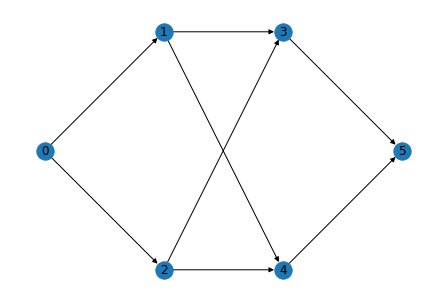

In [11]:
import networkx as nx

name_to_ind = {'s':0, 't':5}
s_ind = 0
t_ind = 5

G = nx.DiGraph()
G.add_weighted_edges_from([(0,1,3),
                  (0,2,3),
                  (1,3,1),
                  (1,4,1),
                  (2,3,1),
                  (2,4,1), 
                  (3,5,3), 
                  (4,5,3)])
pos = {0:[-1,0], 1:[0,1], 2:[0,-1], 3:[1,1],4:[1,-1], 5:[2,0]}

nx.draw(G, with_labels=True, pos=pos)


In [12]:
Graph(G).edmonds_karp(0,5)

print(nx.algorithms.flow.maximum_flow(G, 0, 5, capacity='weight'))
print(nx.algorithms.flow.minimum_cut(G, 0, 5, capacity='weight'))


(4, {0: {1: 2, 2: 2}, 1: {3: 1, 4: 1}, 2: {3: 1, 4: 1}, 3: {5: 2}, 4: {5: 2}, 5: {}})
(4, ({0, 1, 2}, {3, 4, 5}))


In [13]:
graph = Graph(G)
graph.edmonds_karp(0,  5)

(0,
 [[0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]])

## Network Flow optimization
For this exercise, we will use CVXPY which is a Python-embedded modeling language for convex optimization problems. It allows to express problems in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

If CVXPY is not already in your environment, you can install it following the instructions reported [here](https://www.cvxpy.org/install/index.html).

We will consider the same problem as analyzed analytically in Exercise 5/Exercise Session 2. We consider the traffic network with delay functions shown in figure below which is assumed to
have a unit exogenous inflow at node o and a unit exogenous outflow at node d.

![figure](netopt.png)


1.  Determine the social optimum flow using CVXPY. The social optimum flow is defined as the one minimizing the total delay $\sum_{e\in \mathcal{E}} c_e(f_e)$, where on every link $e \in \mathcal{E}$, the cost is $c_e(f_e) = f_e d_e(f_e)$ with $d_e(f_e)$ being the delay function.
2. Determine the flow vector $f$ corresponding to a Wardrop equilibrium by using CVXPY.
3. Replace the delay functions by $\widehat{d}_e(f_e) = d_e(f_e) + \omega_e$, where $\omega_e$ are the tolls computed in Exercise 5-c), i.e., $\omega_1 = 1$, $\omega_2=\omega_3 = 0$, $\omega_4 = 3/2$, and compute by CVXPY the new Wardrop equilibrium with respect to these new delay functions. Compare the resulting flow vector with the socially optimal flow vector for the original delay functions, which was computed in 1. Are the flow vectors equal?

In [16]:
# !pip install ecos==2.0.7rc2
!pip install cvxpy

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Running setup.py clean for ecos
Failed to build ecos scs


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\fabio\appdata\local\programs\python\python39\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Fabio\\AppData\\Local\\Temp\\pip-install-_m9njrw6\\ecos_709ceab8b2d34e1fa47733e4f9b5138c\\setup.py'"'"'; __file__='"'"'C:\\Users\\Fabio\\AppData\\Local\\Temp\\pip-install-_m9njrw6\\ecos_709ceab8b2d34e1fa47733e4f9b5138c\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Fabio\AppData\Local\Temp\pip-wheel-k54l1kl8'
       cwd: C:\Users\Fabio\AppData\Local\Temp\pip-install-_m9njrw6\ecos_709ceab8b2d34e1fa47733e4f9b5138c\
  Complete output (12 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib

### Solution 
Try to solve point 2. and 3. based on the solution for 1. below. 
You can find the complete solution at https://github.com/laura-arditti/Network-Dynamics-and-Learning/blob/main/Lab02.ipynb

First we represent the given graph as a networkx `DiGraph`.

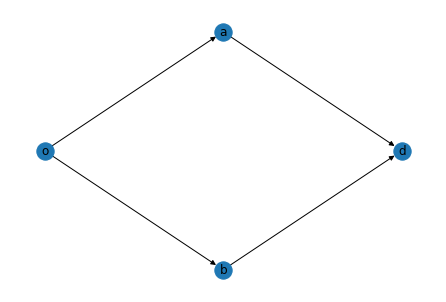

In [14]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('a','d'),('b','d')])
pos = {'o':[0,0], 'a':[1,1], 'b':[1,-1], 'd':[2,0]}
nx.draw(G, with_labels=True, pos=pos)

1.  **Compute social optimum.** The social optimum of the network flow problem can be computed with CVXPY using the following code.


In [15]:
import cvxpy as cp
import numpy as np

# Problem data.

# incidence_matrix(G, oriented=True).toarray() returns  
# the incidence matrix of G as a numpy array. 
# In the matrix returned by incidence_matrix 
# a -1 appears for the source (tail) of an edge 
# and +1 for the destination (head) of the edge.
# This sign convention is opposite to the one we adopt
# for the node-link incidence matrix, so we 
# add a minus sign in front.
B = - nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).toarray() 
n_edges = len(G.edges)
# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
nu = np.array([ 1, 0, 0, -1])
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.
# In this case, the objective function is
# 2 f_1^2 + 2 f_2 + 3 f_3 + 3 f_4^2
Q = np.diag([2,0,0,3]) # diagonal matrix
l = np.array([0,2,3,0]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(cp.quad_form(f, Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Social optimal flow:", f.value)

ModuleNotFoundError: No module named 'cvxpy'

The obtained flow vector is $f = (1/2, 1/2, 1/2, 1/2)'$, which confirms the result obtained in Exercise 5.

2.  **Compute Wardrop equilibrium with tolls.** The flow vector $f^{(0)}$ corresponding to a Wardrop equilibrium can be obtained as a solution of the social optimum problem given that the link cost functions are chosen as
$$
c_e(f_e) = \int_0^{f_e} d_e(s)~\mathrm{d}s.
$$
Computing these cost functions we have
$$
c_1(f_1) = f_1^2, \; c_2(f_2) = 2f_2, \; c_3(f_3) = 3 f_3, \; c_4(f_4) = \frac{3}{2}f_4^2
$$
and again taking the sum of the link costs as the total cost to minimize, the code for finding the Wardrop equilibrium becomes

In [ ]:
# TODO

The result is $f^{(0)} = (0.4, 0.6, 0.4, 0.6)'$, which again confirms the analytically computed result.

3. **Compute Wardrop equilibrium with tolls.** Computing the Wardrop equilibrium as in 2., but with the link delays $d_e(f_e)$ replaced by $\widehat{d}_e(f_e) = d_e(f_e) + \omega_e$, a CVXPY solution can be obtained by the following code:

In [ ]:
# TODO

The resulting flow vector is $f^{(\omega)} = (1/2, 1/2, 1/2, 1/2)'$. This Wardrop equilibrium is equivalent to the social optimum in **1**. We have thus managed to regulate the Wardrop equilibrium so that it corresponds to the social optimum by introducing the road tolls $\omega_e$.